
# Amazon Product Reviews Analysis Notebook

In this notebook, we perform an analysis on Amazon product reviews. We clean the review text, conduct exploratory data analysis (EDA), and build three classification models (Naive Bayes, LinearSVC, and Logistic Regression) to predict sentiment based on review scores.

**Note:** Reviews with a score of 3 are treated as a **neutral** class. This class is used as a catch-all for cases that could potentially be classified erroneously.

## Table of Contents:
1. Data Loading and Preprocessing
2. Exploratory Data Analysis (EDA)
3. Text Cleaning and Word Cloud
4. Balancing the Dataset and Labeling
5. Model Training and Evaluation (Before Combining Summary and Text)
6. Model Training and Evaluation (After Combining Summary and Text)
7. Conclusion


In [4]:
# Import Libraries
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


## 1. Data Loading and Preprocessing

In [ ]:
# Download the latest dataset version from KaggleHub
path = kagglehub.dataset_download("arhamrumi/amazon-product-reviews")
print("Path to dataset files:", path)

# Load the dataset
data = pd.read_csv(r"C:\Users\samuk\.cache\kagglehub\datasets\arhamrumi\amazon-product-reviews\versions\1\Reviews.csv")
data = data.drop(columns="Id")

# Check for null values and drop rows with missing 'ProfileName' or 'Summary'
print(data.isnull().sum())
data = data.dropna(subset=["ProfileName", "Summary"])
print(data.isnull().sum())

# Display summary statistics and dataset information
print(data.describe())
data.info()

Path to dataset files: C:\Users\samuk\.cache\kagglehub\datasets\arhamrumi\amazon-product-reviews\versions\1
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64
       HelpfulnessNumerator  HelpfulnessDenominator          Score  \
count         568401.000000           568401.000000  568401.000000   
mean               1.743903                2.227911       4.183297   
std                7.636845                8.288820       1.310376   
min                0.000000                0.000000       1.000000   
25%

## 2. Exploratory Data Analysis (EDA)

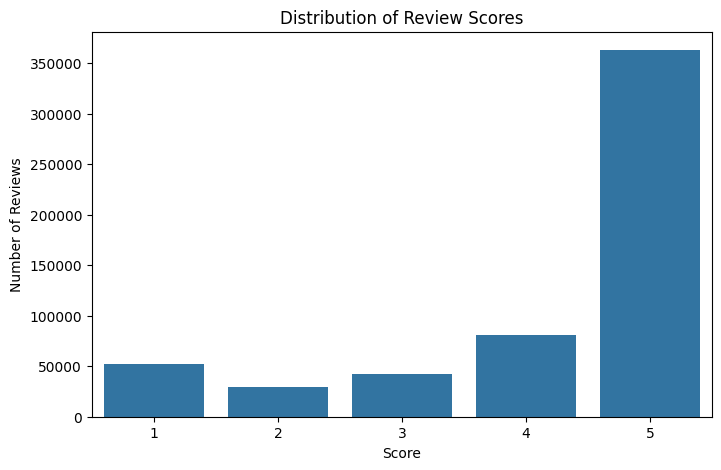

In [6]:
# Plot the distribution of review scores
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x="Score")
plt.title("Distribution of Review Scores")
plt.xlabel("Score")
plt.ylabel("Number of Reviews")
plt.show()

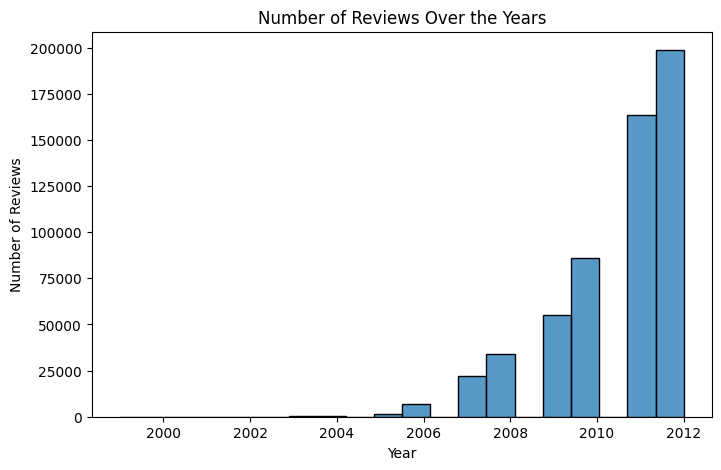

In [7]:
# Convert Unix timestamp to datetime and extract the year
data["Time"] = pd.to_datetime(data["Time"], unit="s")
data["year"] = data["Time"].dt.year

# Plot the number of reviews per year
plt.figure(figsize=(8, 5))
sns.histplot(data["year"], bins=20)
plt.title("Number of Reviews Over the Years")
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.show()

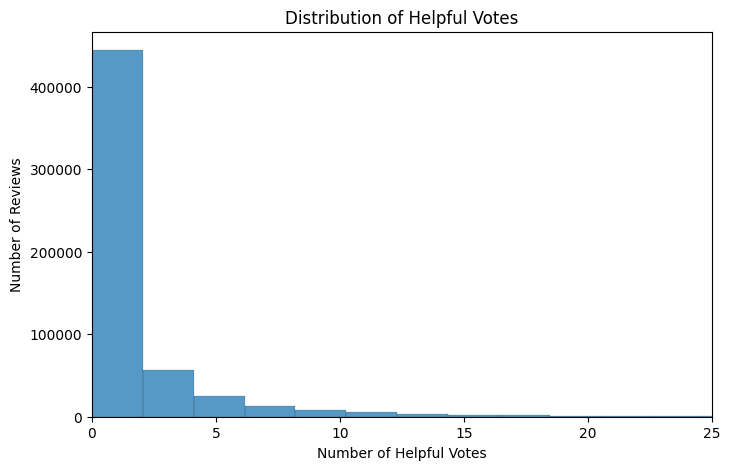

In [8]:
# Plot the distribution of helpful votes (limited x-axis for clarity)
plt.figure(figsize=(8, 5))
sns.histplot(data["HelpfulnessDenominator"], bins=450)
plt.title("Distribution of Helpful Votes")
plt.xlabel("Number of Helpful Votes")
plt.ylabel("Number of Reviews")
plt.xlim(0, 25)
plt.show()

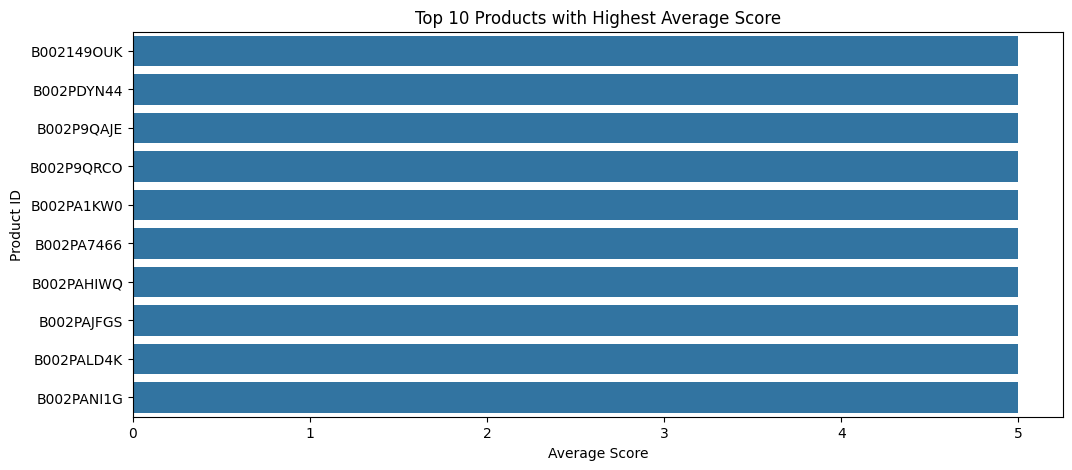

In [9]:
# Top 10 products with the highest average score
top_products = data.groupby("ProductId")["Score"].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 5))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title("Top 10 Products with Highest Average Score")
plt.xlabel("Average Score")
plt.ylabel("Product ID")
plt.show()

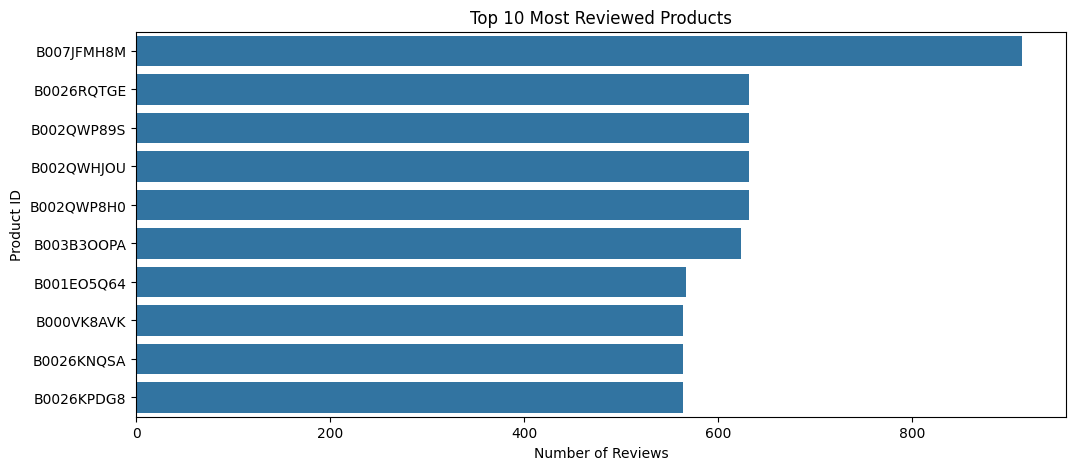

In [10]:
# Top 10 most reviewed products
top_reviewed = data["ProductId"].value_counts().head(10)
plt.figure(figsize=(12, 5))
sns.barplot(x=top_reviewed.values, y=top_reviewed.index)
plt.title("Top 10 Most Reviewed Products")
plt.xlabel("Number of Reviews")
plt.ylabel("Product ID")
plt.show()

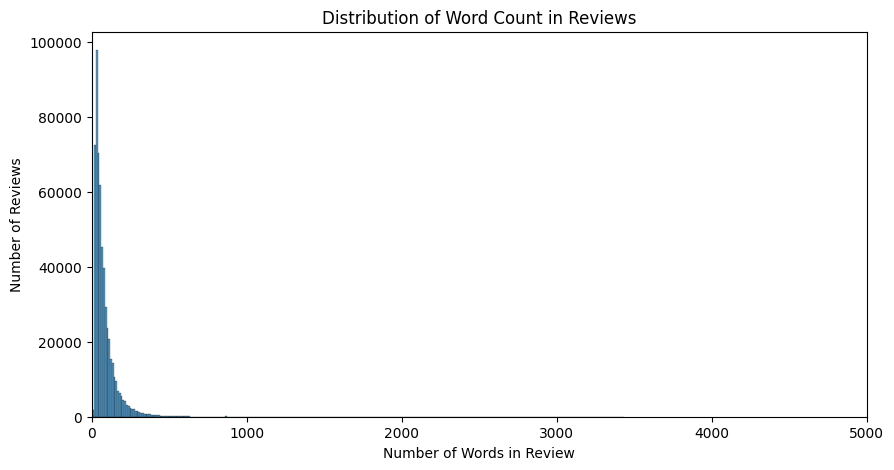

In [11]:
# Add a new column for text length (number of words in the review)
data["text_length"] = data["Text"].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 5))
sns.histplot(data["text_length"], bins=300)
plt.title("Distribution of Word Count in Reviews")
plt.xlabel("Number of Words in Review")
plt.ylabel("Number of Reviews")
plt.xlim(0, 5000)
plt.show()

## 3. Text Cleaning and Word Cloud

In [12]:
# Download NLTK stopwords and initialize the lemmatizer
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Function to clean text: lowercasing, removing stop words, and lemmatization
def clean_text(text):
    words = text.split()
    cleaned_words = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
    return " ".join(cleaned_words)

# Clean the review text
data["text_clean"] = data["Text"].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samuk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


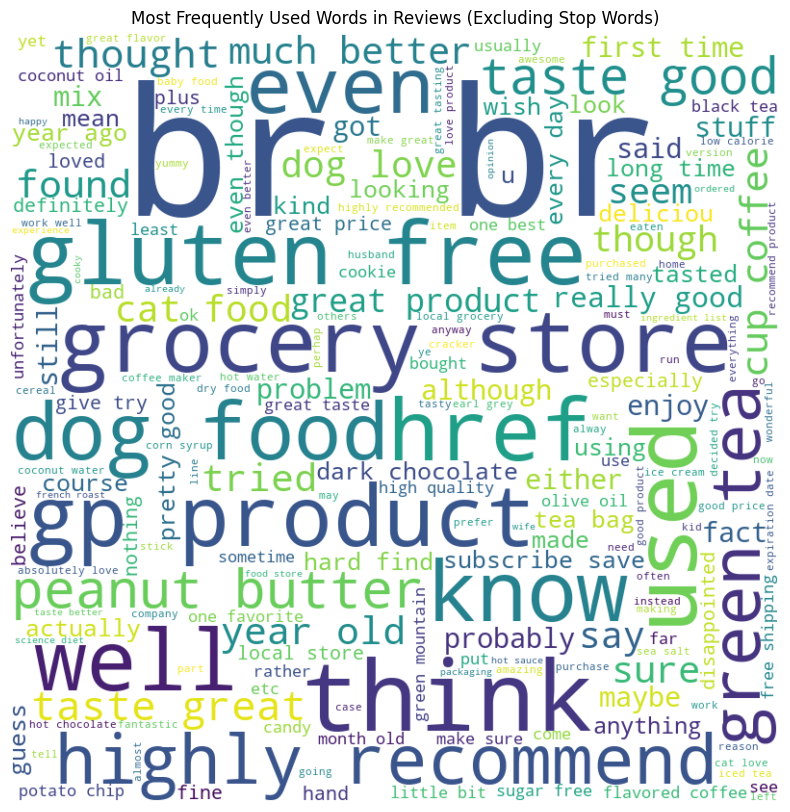

In [13]:
# Generate a Word Cloud for the most frequently used words (excluding stop words)
text_data = " ".join(data["text_clean"].dropna())
wordcloud = WordCloud(width=800, height=800, background_color="white").generate(text_data)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequently Used Words in Reviews (Excluding Stop Words)")
plt.show()

## 4. Balancing the Dataset and Labeling

Minimum number of occurrences for any score: 29743


C:\Users\samuk\AppData\Local\Temp\ipykernel_28308\1808989854.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = data.groupby('Score').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)


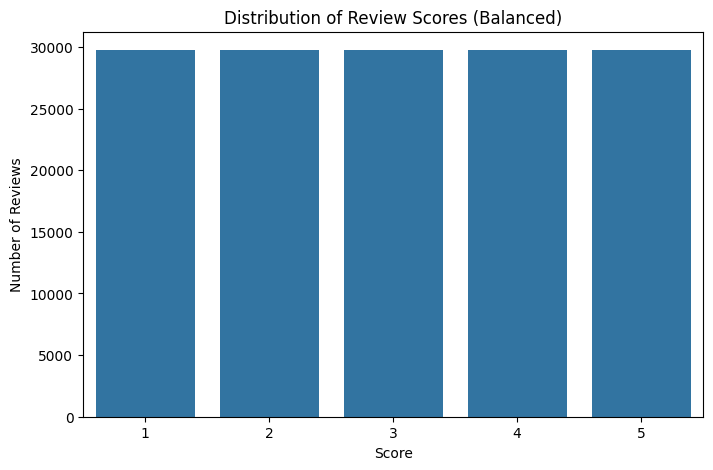

In [14]:
# Balance the dataset by undersampling each score category to the minimum count
min_count = data['Score'].value_counts().min()
print(f"Minimum number of occurrences for any score: {min_count}")

balanced_df = data.groupby('Score').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)

# Plot the balanced score distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=balanced_df, x="Score")
plt.title("Distribution of Review Scores (Balanced)")
plt.xlabel("Score")
plt.ylabel("Number of Reviews")
plt.show()

In [15]:
# Create labels:
# - Reviews with score > 3 are considered positive
# - Reviews with score < 3 are considered negative
# - Reviews with score = 3 are treated as neutral (catch-all for ambiguous cases)
balanced_df["Labels"] = balanced_df["Score"].apply(
    lambda x: "positive" if x > 3 else ("negative" if x < 3 else "neutral")
)

# Encode the labels for model training
encoder = LabelEncoder()
balanced_df["Labels_encoded"] = encoder.fit_transform(balanced_df["Labels"])

## 5. Model Training and Evaluation (Before Combining Summary and Text)

In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    balanced_df['text_clean'], balanced_df['Labels_encoded'], test_size=0.2, random_state=42
)

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1, 3))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Apply SMOTE to address any class imbalance in the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)

In [18]:
# 1. Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train_res, y_train_res)
y_pred_nb = nb_model.predict(X_test_tfidf)
print("Naive Bayes:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb)}")
print(classification_report(y_test, y_pred_nb))

Naive Bayes:
Accuracy: 0.6721917762162526
              precision    recall  f1-score   support

           0       0.77      0.68      0.72     11872
           1       0.39      0.58      0.47      5859
           2       0.81      0.71      0.75     12012

    accuracy                           0.67     29743
   macro avg       0.65      0.66      0.65     29743
weighted avg       0.71      0.67      0.68     29743



In [19]:
# 2. Linear SVC with GridSearchCV
parameters = {'C': [0.1, 1, 10]}
svc = LinearSVC()
grid_search = GridSearchCV(svc, parameters, cv=3, n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)
print(f"Best Parameters: {grid_search.best_params_}")
y_pred_svc = grid_search.predict(X_test_tfidf)
print("LinearSVC (with GridSearch):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svc)}")
print(classification_report(y_test, y_pred_svc))

Best Parameters: {'C': 1}
LinearSVC (with GridSearch):
Accuracy: 0.7243384998150826
              precision    recall  f1-score   support

           0       0.80      0.75      0.77     11872
           1       0.47      0.58      0.51      5859
           2       0.82      0.77      0.80     12012

    accuracy                           0.72     29743
   macro avg       0.69      0.70      0.69     29743
weighted avg       0.74      0.72      0.73     29743



Logistic Regression:
Accuracy: 0.7244729852402246
              precision    recall  f1-score   support

           0       0.80      0.74      0.77     11872
           1       0.46      0.60      0.52      5859
           2       0.83      0.77      0.80     12012

    accuracy                           0.72     29743
   macro avg       0.70      0.70      0.70     29743
weighted avg       0.75      0.72      0.73     29743

Cross-Validation Accuracy: 0.731780847969669


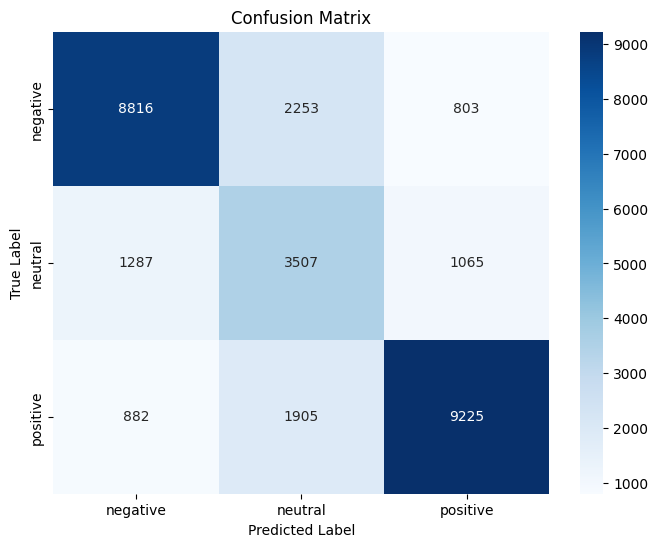

In [20]:
# 3. Logistic Regression Model
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_model.fit(X_train_res, y_train_res)
y_pred_lr = lr_model.predict(X_test_tfidf)
print("Logistic Regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr)}")
print(classification_report(y_test, y_pred_lr))

# Cross-Validation for Logistic Regression
cv_results = cross_val_score(lr_model, X_train_res, y_train_res, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_results.mean()}")

# Plot the Confusion Matrix for Logistic Regression
conf_matrix = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 6. Model Training and Evaluation (After Combining Summary and Text)

In this section, we combine the `Summary` and `Text` fields to create a more comprehensive text feature.

In [21]:
# Combine the Summary and Text columns into a single text field and clean it
df = data.copy()
df["text_combined"] = df["Summary"] + " " + df["Text"]
df["text_clean"] = df["text_combined"].apply(clean_text)

# Balance the dataset based on the combined text
min_count = df['Score'].value_counts().min()
print(f"Minimum number of occurrences for any score: {min_count}")

balanced_dfa = df.groupby('Score').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)

# Create labels for the combined text dataset
balanced_dfa["Labels"] = balanced_dfa["Score"].apply(
    lambda x: "positive" if x > 3 else ("negative" if x < 3 else "neutral")
)
balanced_dfa["Labels_encoded"] = encoder.fit_transform(balanced_dfa["Labels"])

Minimum number of occurrences for any score: 29743


C:\Users\samuk\AppData\Local\Temp\ipykernel_28308\2568024685.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_dfa = df.groupby('Score').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)


In [22]:
# Split the combined text data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    balanced_dfa['text_clean'], balanced_dfa['Labels_encoded'], test_size=0.2, random_state=42
)

# Vectorize the combined text using TF-IDF
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1, 3))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Apply SMOTE to the combined text training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)

In [23]:
# 1. Naive Bayes Model on Combined Text
nb_model = MultinomialNB()
nb_model.fit(X_train_res, y_train_res)
y_pred_nb = nb_model.predict(X_test_tfidf)
print("Naive Bayes (Combined Text):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb)}")
print(classification_report(y_test, y_pred_nb))

Naive Bayes (Combined Text):
Accuracy: 0.6943146286521198
              precision    recall  f1-score   support

           0       0.79      0.70      0.74     11872
           1       0.41      0.60      0.49      5859
           2       0.83      0.74      0.78     12012

    accuracy                           0.69     29743
   macro avg       0.68      0.68      0.67     29743
weighted avg       0.73      0.69      0.71     29743



In [24]:
# 2. Linear SVC with GridSearchCV on Combined Text
grid_search = GridSearchCV(LinearSVC(), parameters, cv=3, n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)
print(f"Best Parameters: {grid_search.best_params_}")
y_pred_svc = grid_search.predict(X_test_tfidf)
print("LinearSVC (with GridSearch, Combined Text):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svc)}")
print(classification_report(y_test, y_pred_svc))

Best Parameters: {'C': 1}
LinearSVC (with GridSearch, Combined Text):
Accuracy: 0.7543623709780453
              precision    recall  f1-score   support

           0       0.82      0.77      0.79     11872
           1       0.50      0.61      0.55      5859
           2       0.84      0.81      0.83     12012

    accuracy                           0.75     29743
   macro avg       0.72      0.73      0.72     29743
weighted avg       0.77      0.75      0.76     29743



Fitting 5 folds for each of 810 candidates, totalling 4050 fits


c:\Users\samuk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
2100 fits failed out of a total of 4050.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
450 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\samuk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\samuk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\samuk\AppData\Local\Programs\Python\Python310\lib\site-pa

Najlepsze parametry: {'C': 10, 'class_weight': 'balanced', 'max_iter': 500, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga'}
Logistic Regression (Combined Text):
Accuracy: 0.7528157885889116
              precision    recall  f1-score   support

           0       0.82      0.77      0.79     11872
           1       0.49      0.62      0.55      5859
           2       0.85      0.80      0.83     12012

    accuracy                           0.75     29743
   macro avg       0.72      0.73      0.72     29743
weighted avg       0.77      0.75      0.76     29743



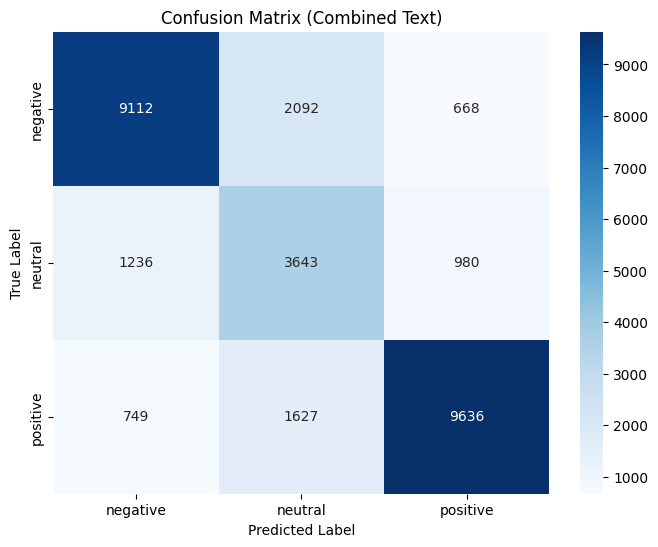

In [ ]:
# 3. Logistic Regression Model on Combined Text
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_model.fit(X_train_res, y_train_res)
y_pred_lr = lr_model.predict(X_test_tfidf)
print("Logistic Regression (Combined Text):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr)}")
print(classification_report(y_test, y_pred_lr))

# Cross-Validation for Logistic Regression on combined text
cv_results = cross_val_score(lr_model, X_train_res, y_train_res, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (Combined Text): {cv_results.mean()}")

# Plot the Confusion Matrix for Logistic Regression on combined text
conf_matrix = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Confusion Matrix (Combined Text)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 7. Conclusion

**Before Combining Summary and Text:**

- **Naive Bayes:** Accuracy ~67.2%
- **LinearSVC (with GridSearch, C=1):** Accuracy ~72.4%
- **Logistic Regression:** Accuracy ~72.4%

**After Combining Summary and Text:**

- **Naive Bayes:** Accuracy ~69.4%
- **LinearSVC (with GridSearch, C=1):** Accuracy ~75.4%
- **Logistic Regression:** Accuracy ~75.4%

**Observations:**

- Combining the `Summary` and `Text` fields provides richer contextual information, leading to improved model performance across the board.
- The neutral class (score = 3) acts as a buffer for ambiguous reviews, which can be challenging for classification models.
- Among the models, both LinearSVC and Logistic Regression show a noticeable performance boost after combining the text features.

Overall, this analysis demonstrates the importance of feature engineering (in this case, combining text fields) and careful preprocessing in improving classification accuracy.